In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import sklearn as skl
import tensorflow as tf
import yfinance as yf
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
from pathlib import Path
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import json
import os
import pymongo
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
import seaborn as sb
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [2]:
client = MongoClient("mongodb://localhost:27017/Group_Project")
db=client.Group_Project

In [11]:
SoyOil=pd.DataFrame(list(db.SoyOil.find())).drop("_id",axis=1)

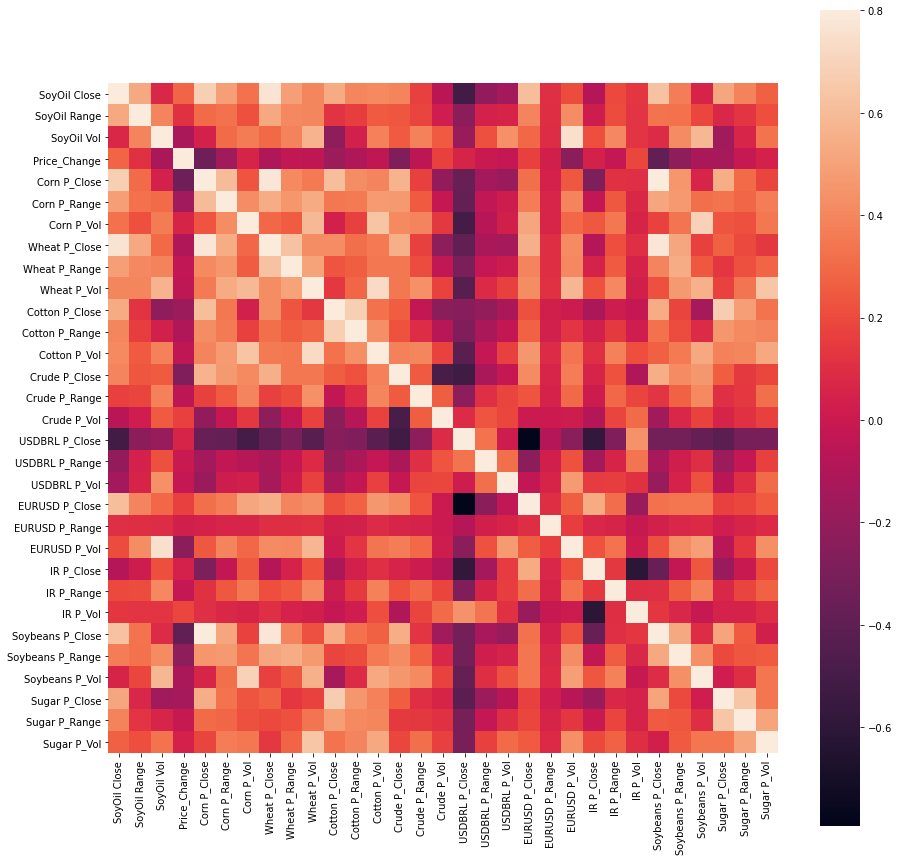

In [13]:
C_mat = SoyOil.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax=.8, square =True)
plt.show()

In [14]:
App_cat = SoyOil.dtypes[SoyOil.dtypes == "object"].index.tolist()

enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(SoyOil[App_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(App_cat)
encode_df.head()

,Buy/Hold_Buy,Buy/Hold_Hold
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [15]:
SoyOil = SoyOil.merge(encode_df,left_index=True, right_index=True)
SoyOil = SoyOil.drop(App_cat,1)
SoyOil.head()

,SoyOil Close,SoyOil Range,SoyOil Vol,Price_Change,Corn P_Close,Corn P_Range,Corn P_Vol,Wheat P_Close,Wheat P_Range,Wheat P_Vol,...,IR P_Range,IR P_Vol,Soybeans P_Close,Soybeans P_Range,Soybeans P_Vol,Sugar P_Close,Sugar P_Range,Sugar P_Vol,Buy/Hold_Buy,Buy/Hold_Hold
0,54.259998,1.190002,0.246321,0.606276,401.0,8.00,0.234556,608.00,12.50,0.279679,...,0.025,0.656190,1059.00,17.50,0.172572,14.72,0.57,0.291503,1.0,0.0
1,54.599998,1.399998,0.247860,0.645074,397.5,4.75,0.234100,607.50,18.50,0.283180,...,0.027,0.660260,1050.75,11.50,0.172270,14.97,0.81,0.292519,1.0,0.0
2,55.090000,1.349998,0.248301,0.639095,398.5,5.75,0.236894,598.50,12.00,0.282717,...,0.049,0.660369,1056.50,15.25,0.172052,14.36,0.50,0.284243,1.0,0.0
3,55.090000,0.750000,0.249832,0.666364,398.5,11.25,0.236926,603.75,12.75,0.282817,...,0.073,0.661255,1051.75,11.25,0.172080,14.40,0.50,0.284261,1.0,0.0
4,56.889999,0.000000,0.244642,0.702274,401.5,14.75,0.237179,608.75,13.75,0.282501,...,0.037,0.651831,1057.25,25.00,0.171875,14.89,0.33,0.279296,1.0,0.0


In [16]:
# Split our preprocessed data into our features and target arrays
yS = SoyOil["Buy/Hold_Hold"].values
XS = SoyOil.drop(["Buy/Hold_Hold"],1).values

# Split the preprocessed data into a training and testing dataset
XS_train, XS_test, yS_train, yS_test = train_test_split(XS, yS, random_state=78)

In [17]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
XS_scaler = scaler.fit(XS_train)
XS_scaler
#Scale the data
XS_train_scaled = XS_scaler.transform(XS_train)
XS_test_scaled = XS_scaler.transform(XS_test)

In [18]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(XS_train[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30




nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))



# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                2640      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 5,101
Trainable params: 5,101
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [20]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [21]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=1000)

In [22]:
# Train the model
fit_model = nn.fit(XS_train_scaled,yS_train,epochs=100, callbacks=[cp_callback])

Epoch 1/100
93/93 [==============================] - 0s 704us/step - loss: nan - accuracy: 0.6716
Epoch 2/100
93/93 [==============================] - 0s 642us/step - loss: nan - accuracy: 0.7008
Epoch 3/100
93/93 [==============================] - 0s 656us/step - loss: nan - accuracy: 0.6971
Epoch 4/100
93/93 [==============================] - 0s 690us/step - loss: nan - accuracy: 0.6921
Epoch 5/100
93/93 [==============================] - 0s 593us/step - loss: nan - accuracy: 0.7008
Epoch 6/100
93/93 [==============================] - 0s 638us/step - loss: nan - accuracy: 0.6990
Epoch 7/100
93/93 [==============================] - 0s 674us/step - loss: nan - accuracy: 0.6808
Epoch 8/100
93/93 [==============================] - 0s 650us/step - loss: nan - accuracy: 0.7091
Epoch 9/100
93/93 [==============================] - 0s 629us/step - loss: nan - accuracy: 0.6854
Epoch 10/100
93/93 [==============================] - 0s 672us/step - loss: nan - accuracy: 0.6748
Epoch 11/100
 1/93 

93/93 [==============================] - 0s 760us/step - loss: nan - accuracy: 0.6994
Epoch 76/100
 1/93 [..............................] - ETA: 0s - loss: nan - accuracy: 0.7188
Epoch 00076: saving model to checkpoints\weights.76.hdf5
93/93 [==============================] - 0s 797us/step - loss: nan - accuracy: 0.7028
Epoch 77/100
93/93 [==============================] - 0s 715us/step - loss: nan - accuracy: 0.7100
Epoch 78/100
93/93 [==============================] - 0s 687us/step - loss: nan - accuracy: 0.7078
Epoch 79/100
93/93 [==============================] - 0s 646us/step - loss: nan - accuracy: 0.6972
Epoch 80/100
93/93 [==============================] - 0s 650us/step - loss: nan - accuracy: 0.7055
Epoch 81/100
93/93 [==============================] - 0s 705us/step - loss: nan - accuracy: 0.7020
Epoch 82/100
93/93 [==============================] - 0s 642us/step - loss: nan - accuracy: 0.6943
Epoch 83/100
93/93 [==============================] - 0s 641us/step - loss: nan - ac

In [23]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(XS_test_scaled,yS_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

31/31 - 0s - loss: nan - accuracy: 0.6909
Loss: nan, Accuracy: 0.6909090876579285
